<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

<a id="concept"></a>
# <center>Custom Callback Concept</center>
This notebook implements a custom callback to adjust the learning rate during training.  
The callback has a parameter dwell. If dwell is set to True, the callback monitors the  
validation loss. It keeps track of the lowest validation loss thus far achieved as you run  
through each epoch and stores this as the lowest loss and also stores the weights for that  
epoch as the best weights. At the end of an epoch the validation loss for that epoch is  
compared with the lowest loss. If the validation loss at the end of the current epoch is  
less than the lowest loss than it becomes the lowest loss and the weights of the current  
epoch become the best weights  
  
If the validation loss at the end of the current epoch is greator than the lowest loss    
this implies you have moved to a location in Nspace(N is the number of trainable parameters    
on the validation cost function surface that is less favorable(higher cost) than the position  
in Nspace defined by the best weights. Therefore why move the models weights to this less  
favorable location? Better to reset the models weights to the best weights, then lower the  
learning rate and run more epochs. The new learning rate is set to new_lr=current_lr * factor  
where factor is a user specified parameter in the instantiation of the callback. By default  
it is set to .04 and by default dwell is set to True.  
  
At the end of training the callback always returns your model with the weights set to the  
best weights. The callback provides a feature where it periodically queries the user to  
either contine and optionally manually specify a new learning rate or halt training.  
During training the calback provides useful information on the percent improvement in the  
validation loss for each epoch. The is useful to decide when to halt training or manually  
specifying a new learning rate.  

<a id="pc"></a>

<a id="makedf"></a>
# <center>Read in image paths and labels and create train, test and validation data frames</center>


In [2]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                if 'mask' not in fpath:
                    filepaths.append(fpath)
                    labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts()) 
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)
    

normal                   : 100%|█████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 312254.37files/s]


number of classes in processed dataset=  3
306 <class 'int'>
the maximum files in any class in train_df is  306   the minimum files in any class in train_df is  93
train_df length:  546   test_df length:  117   valid_df length:  117
average image height=  515   average image width=  636  aspect ratio h/w=  0.809748427672956


<a id="trim"></a>
## <center>Trim train_df so no class has more than max_samples images </center>

In [3]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=300
min_samples=93
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  546  with  3  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  93
the trimmed dataframe now is of length  540  with  3  classes


<a id="balance"></a>
## <center>Expand train_df rows with augmented images so each class has 300 samples</center>


In [4]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 


n=300 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,260) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)  


Initial length of dataframe is  540
Found 93 validated image filenames.      for class             normal             creating  207  augmented images 
Found 147 validated image filenames.     for class           malignant            creating  153  augmented images 
Total Augmented images created=  360
Length of augmented dataframe is now  900


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [5]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 900 validated image filenames belonging to 3 classes.            for train generator 
Found 117 validated image filenames belonging to 3 classes.            for valid generator 
Found 117 validated image filenames belonging to 3 classes.            for test generator 
test batch size:  39   test steps:  3  number of classes :  3


<a id="show"></a>
# <center>Create a function to show example training images</center>

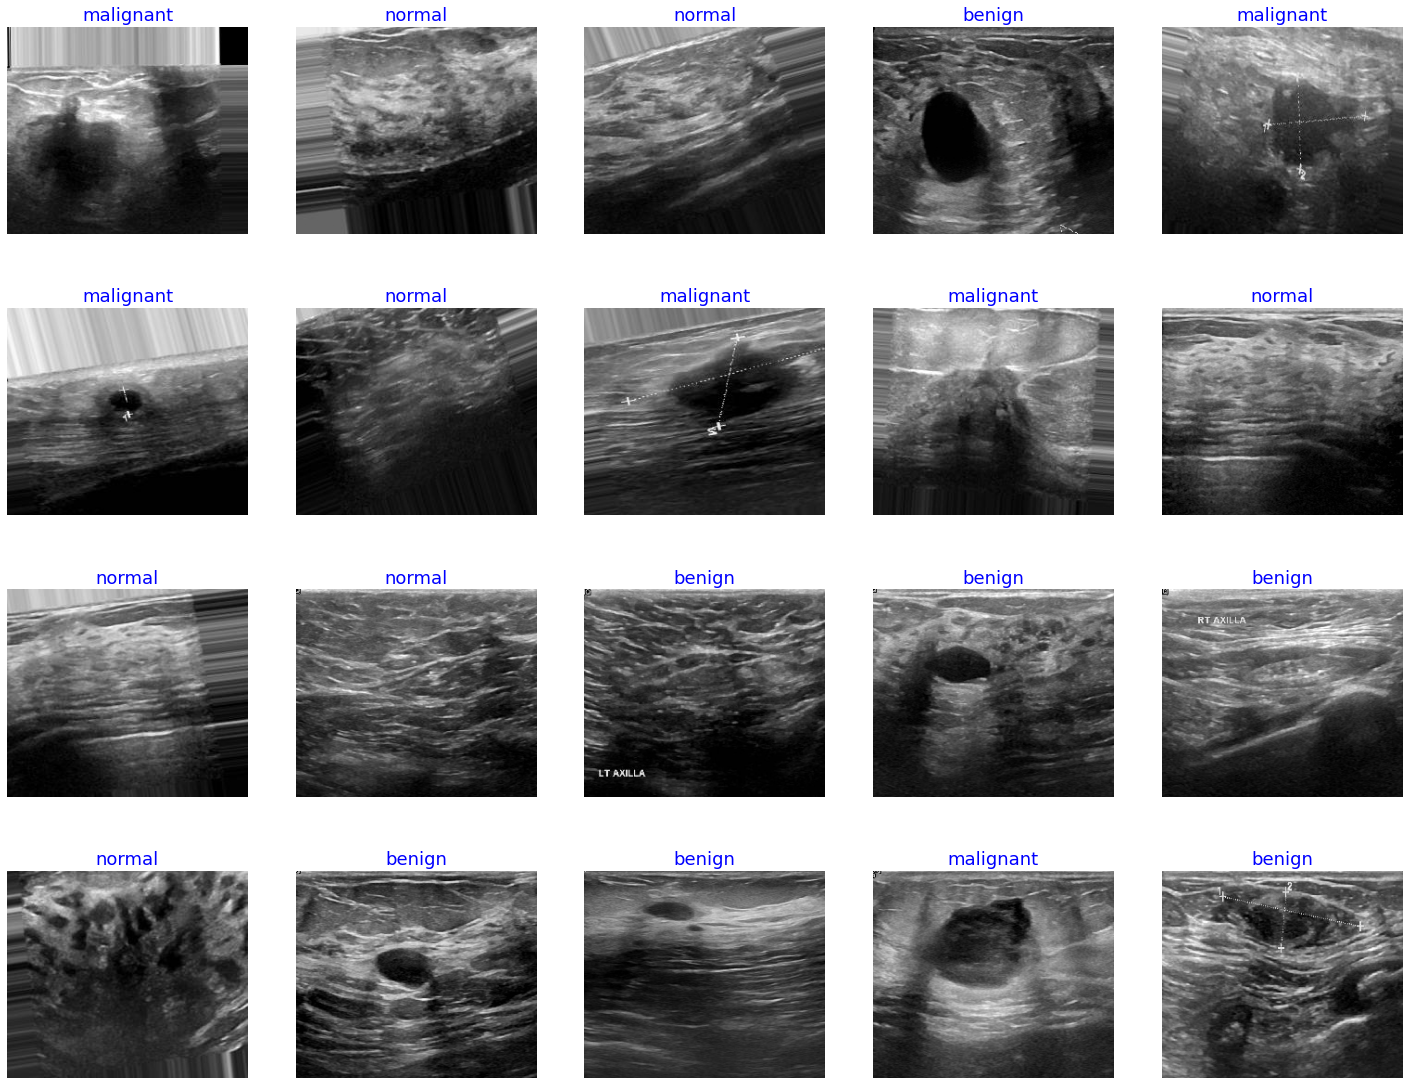

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [7]:
def make_model(img_size, lr, mod_num):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model

lr=.001
model=make_model(img_size, lr,mod_num=5)

115277824/115263384 [==============================] - 1s 0us/step
Created EfficientNet B5 model with initial learning rate set to 0.001


<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [8]:
# class LR_ASK(keras.callbacks.Callback):
#     def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
#         super(LR_ASK, self).__init__()
#         self.model=model               
#         self.ask_epoch=ask_epoch
#         self.epochs=epochs
#         self.ask=True # if True query the user on a specified epoch
#         self.lowest_vloss=np.inf
#         self.lowest_aloss=np.inf
#         self.best_weights=self.model.get_weights() # set best weights to model's initial weights
#         self.best_epoch=1
#         self.plist=[]
#         self.alist=[]
#         self.dwell= dwell
#         self.factor=factor
        
#     def get_list(self): # define a function to return the list of % validation change
#         return self.plist, self.alist
#     def on_train_begin(self, logs=None): # this runs on the beginning of training
#         if self.ask_epoch == 0: 
#             print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
#             self.ask_epoch=1
#         if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
#             print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
#             self.ask=False # do not query the user
#         if self.epochs == 1:
#             self.ask=False # running only for 1 epoch so do not query user
#         else:
#             msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
#             print_in_color(msg )
#             msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
#             print_in_color(msg)
#             if self.dwell:
#                 msg='learning rate will be automatically adjusted during training'
#                 print_in_color(msg, (0,255,0))
#         self.start_time= time.time() # set the time at which training started
       
#     def on_train_end(self, logs=None):   # runs at the end of training  
#         msg=f'loading model with weights from epoch {self.best_epoch}'
#         print_in_color(msg, (0,255,255))
#         model.set_weights(self.best_weights) # set the weights of the model to the best weights
#         tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
#         hours = tr_duration // 3600
#         minutes = (tr_duration - (hours * 3600)) // 60
#         seconds = tr_duration - ((hours * 3600) + (minutes * 60))
#         msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
#         print_in_color (msg) # print out training duration time
        
#     def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
#         vloss=logs.get('val_loss')  # get the validation loss for this epoch
#         aloss=logs.get('loss')
#         if epoch >0:
#             deltav = self.lowest_vloss- vloss 
#             pimprov=(deltav/self.lowest_vloss) * 100 
#             self.plist.append(pimprov)
#             deltaa=self.lowest_aloss-aloss
#             aimprov=(deltaa/self.lowest_aloss) * 100
#             self.alist.append(aimprov)
#         else:
#             pimprov=0.0 
#             aimprov=0.0
#         if vloss< self.lowest_vloss:
#             self.lowest_vloss=vloss
#             self.best_weights=self.model.get_weights() # set best weights to model's initial weights
#             self.best_epoch=epoch + 1            
#             msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
#             print_in_color(msg, (0,255,0)) # green foreground
#         else: # validation loss increased
#             pimprov=abs(pimprov)
#             msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
#             print_in_color(msg, (255,255,0)) # yellow foreground
#             if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
#                 lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
#                 new_lr=lr * self.factor
#                 msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
#                 print_in_color(msg) # cyan foreground
#                 tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
#                 model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
#         if aloss< self.lowest_aloss:
#             self.lowest_aloss=aloss        
#         if self.ask: # are the conditions right to query the user?
#             if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
#                 msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
#                 print_in_color(msg) # cyan foreground
#                 ans=input()
                
#                 if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
#                     msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
#                     print_in_color(msg)
#                     self.model.stop_training = True # halt training
#                 else: # user wants to continue training
#                     self.ask_epoch += int(ans)
#                     if self.ask_epoch > self.epochs:
#                         print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
#                     else:
#                         msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
#                         print_in_color(msg) # cyan foreground
#                         if self.dwell==False:
#                             lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
#                             msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
#                             print_in_color(msg) # cyan foreground
#                             ans=input(' ')
#                             if ans =='':
#                                 msg=f'keeping current LR of {lr:7.5f}'
#                                 print_in_color(msg) # cyan foreground
#                             else:
#                                 new_lr=float(ans)
#                                 tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
#                                 msg=f' changing LR to {ans}'
#                                 print_in_color(msg) # cyan foreground

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [ ]:
# epochs=40
# ask_epoch=10
# ask=LR_ASK(model, epochs,  ask_epoch)
# callbacks=[ask]

In [14]:
epochs=40
callbacks=[reduce_lr, early_stopping, checkpoint]

In [12]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [13]:
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 5,
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000000001
)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max",
)

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "bcpred_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have always found this to be true

In [15]:

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False)

Epoch 1/40
45/45 [==============================] - 62s 734ms/step - loss: 8.6672 - accuracy: 0.6633 - val_loss: 10.2323 - val_accuracy: 0.6154

Epoch 00001: val_accuracy improved from -inf to 0.61538, saving model to bcpred_.01-0.615385.hdf5
Epoch 2/40
45/45 [==============================] - 27s 598ms/step - loss: 7.1750 - accuracy: 0.8467 - val_loss: 7.8732 - val_accuracy: 0.6923

Epoch 00002: val_accuracy improved from 0.61538 to 0.69231, saving model to bcpred_.02-0.692308.hdf5
Epoch 3/40
45/45 [==============================] - 27s 596ms/step - loss: 6.1904 - accuracy: 0.9244 - val_loss: 7.1018 - val_accuracy: 0.6838

Epoch 00003: val_accuracy did not improve from 0.69231
Epoch 4/40
45/45 [==============================] - 27s 599ms/step - loss: 5.4586 - accuracy: 0.9600 - val_loss: 6.2431 - val_accuracy: 0.7009

Epoch 00004: val_accuracy improved from 0.69231 to 0.70085, saving model to bcpred_.04-0.700855.hdf5
Epoch 5/40
45/45 [==============================] - 27s 595ms/step -

<a id="plot"></a>
# <center>Define a function to plot the training data

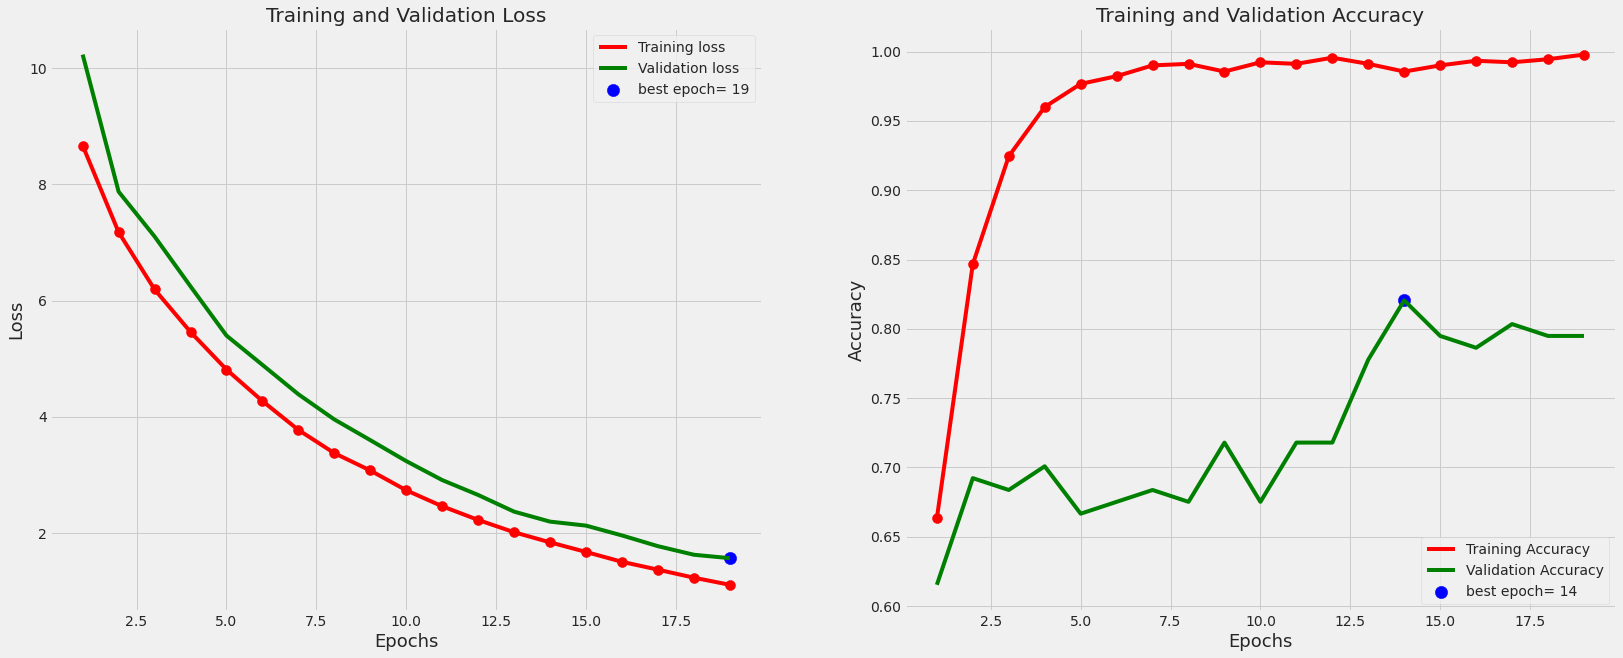

In [16]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

<a> id="result"</a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

3/3 [==============================] - 5s 594ms/step
there were 19 errors in 117 tests for an accuracy of  83.76 (0, 255, 255) (100, 100, 100)


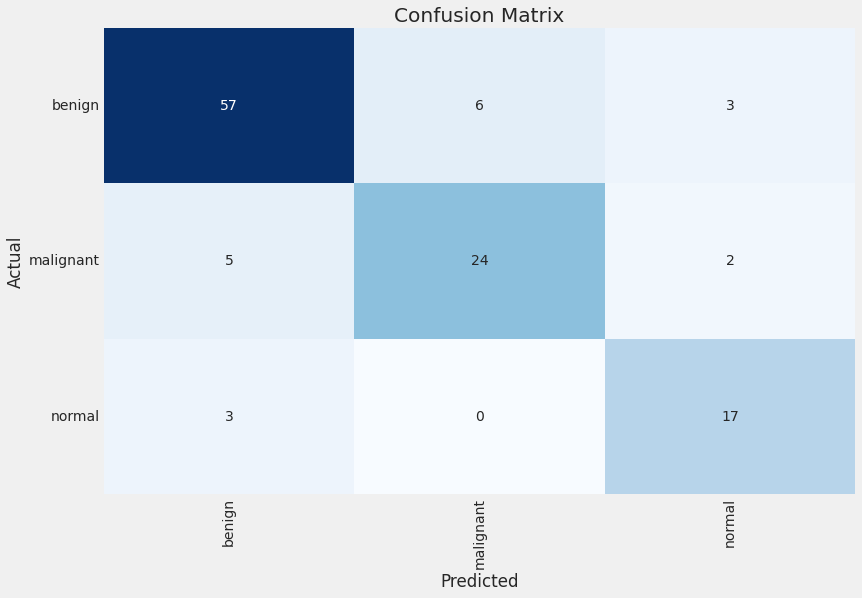

Classification Report:
----------------------
               precision    recall  f1-score   support

      benign     0.8769    0.8636    0.8702        66
   malignant     0.8000    0.7742    0.7869        31
      normal     0.7727    0.8500    0.8095        20

    accuracy                         0.8376       117
   macro avg     0.8166    0.8293    0.8222       117
weighted avg     0.8387    0.8376    0.8378       117



In [17]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):  
        file=test_gen.filenames[i]        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score

errors, tests, error_list, f1score =predictor(test_gen)

In [ ]:
model.save()

In [ ]:
if len(error_list) > 0 and len(error_list)<50:    
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))   
    sorted_list=sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i][0]         
        split=fpath.split('/')  
        
        f=split[4] + split[5]
        pred_class=sorted_list[i][1]
        print(f'{f:^30s}{pred_class:^30s}')
        

<a id="save"></a>
# <center>Save the model

In [ ]:
subject='ultrasound' 
save_id=f'{subject}-{f1score:5.2f}.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
msg= f'model was saved as {model_save_loc}'
print(msg, (0,255,255), (100,100,100)) 

In [ ]:
from IPython.display import FileLink
FileLink(r'ultrasound-89.88.h5')

In [ ]:
import tensorflow
tensorflow.__version__

In [ ]:
img_size

In [20]:
img = '../input/xxxxxx/1benignbc.png'
import cv2
image = cv2.imread(img)

In [27]:
re = image.reshape(1,224,260,3)

In [28]:
re.shape

(1, 224, 260, 3)

In [31]:
pred = model.predict(re)

In [32]:
pred_index=np.argmax(pred)         
true_index=test_gen.labels[pred_index]

In [33]:
true_index

0

In [36]:
pred_index

2